In [1]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import json

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from nerfstudio.model_components.ray_generators import RayGenerator
from nerfstudio.models.instant_ngp import NGPModel

from nerfstudio.scripts.eval import eval_setup

ModuleNotFoundError: No module named 'style_ngp'

In [12]:
config_path = Path(
    "/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/config.yml")
_, pipeline, _, _ = eval_setup(config_path=config_path, test_mode="inference")
nerf_model = pipeline.model
assert isinstance(nerf_model, NGPModel), "pipeline.model is not of type NGPModel"
nerf_device = nerf_model.device

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/nerfstudio_models/step-000018000.ckpt

In [3]:
def image_to_tensor(image_path, device) -> torch.Tensor:
    # Open the image using PIL
    image = Image.open(image_path).convert("RGB")

    # Define the transform to convert the image to a PyTorch tensor
    transform = transforms.ToTensor()  # This will convert to a tensor with shape (C, H, W)

    # Apply the transform
    tensor = transform(image)  # Shape will be (3, 512, 512)

    # Permute the tensor to get shape (512, 512, 3)
    tensor = tensor.permute(1, 2, 0).to(device)

    return tensor.detach().requires_grad_(False)

def show_image(tensor):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.array(tensor))
    plt.axis('off')
    plt.show()

In [4]:
# custom nerfstudio transformation
dataparser_transforms_path = Path(
    "/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/dataparser_transforms.json")

with open(dataparser_transforms_path, "r") as f:
    dataparser_transform = json.load(f)

dataparser_matrix = torch.tensor(dataparser_transform["transform"], dtype=torch.float32)
dataparser_matrix = np.vstack((dataparser_matrix, np.array([[0, 0, 0, 1]])))
dataparser_scale = dataparser_transform["scale"]


In [5]:
data_transform_matrix = np.array([
    [-0.16551750084030392, 0.17173068552312126, -0.9711398089695112, -80.73672706466026],
    [-0.9756847655052445, 0.11494663876681419, 0.18661861803471735, 15.51473463480075],
    [0.14367740002017088, 0.9784149640546033, 0.14852933325600515, 12.348141976499424],
    [0, 0, 0, 1],
])

camera_params = {
    "camera_angle_x": 0.5235987755982988,
    "camera_angle_y": 0.5235987755982988,
    "fl_x": 955.4050067376327,
    "fl_y": 955.4050067376327,
    "k1": 0,
    "k2": 0,
    "k3": 0,
    "k4": 0,
    "p1": 0,
    "p2": 0,
    "is_fisheye": False,
    "cx": 256.0,
    "cy": 256.0,
    "w": 512,
    "h": 512,
    "aabb_scale": 32,
}

final_matrix_np = np.dot(dataparser_matrix, data_transform_matrix)
final_matrix_np[:3, 3] = final_matrix_np[:3, 3] * dataparser_scale
final_matrix_np = final_matrix_np[:3, :4]

final_matrix = nn.Parameter(torch.tensor(final_matrix_np, dtype=torch.float32).unsqueeze(0).to(nerf_device), requires_grad=True)

final_matrix, final_matrix.shape, final_matrix.is_leaf, final_matrix.requires_grad

# should look like this:
# actual_transform_matrix = np.array([
#     [-0.2205035537481308, -0.21815498173236847, -0.9506769180297852, -0.11759857088327408],
#     [-0.9667345285415649, 0.17840947210788727, 0.1832878142595291, 0.23202396929264069],
#     [0.129624605178833, 0.9594677686691284, -0.2502378523349762, -0.26915040612220764],
# ])

(Parameter containing:
 tensor([[[-0.2205, -0.2182, -0.9507, -0.1176],
          [-0.9667,  0.1784,  0.1833,  0.2320],
          [ 0.1296,  0.9595, -0.2502, -0.2692]]], device='cuda:0',
        requires_grad=True),
 torch.Size([1, 3, 4]),
 True,
 True)

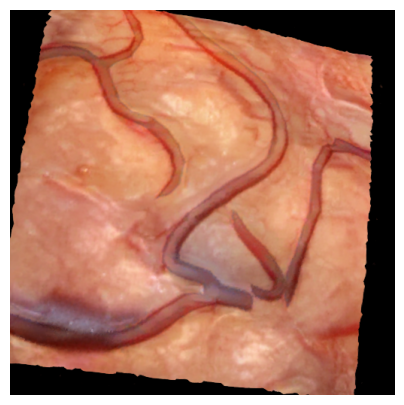

(torch.Size([512, 512, 3]), True, device(type='cuda', index=0))

In [6]:
camera = pipeline.datamanager.train_dataset.cameras[0].to(nerf_device)
camera.camera_to_worlds = final_matrix

rendered_image = nerf_model.get_outputs_for_camera(camera)["rgb"]
rendered_image.requires_grad = True
show_image(rendered_image.cpu().detach().numpy())
rendered_image.shape, rendered_image.requires_grad, rendered_image.device

# rendered_image_2 = nerf_model.get_outputs_for_camera_ray_bundle(camera.generate_rays(camera_indices=0, keep_shape=True, obb_box=None))
# rendered_image_3 = nerf_model.forward()

In [8]:
outs = nerf_model.get_outputs(camera)

TypeError: len() of a 0-d tensor

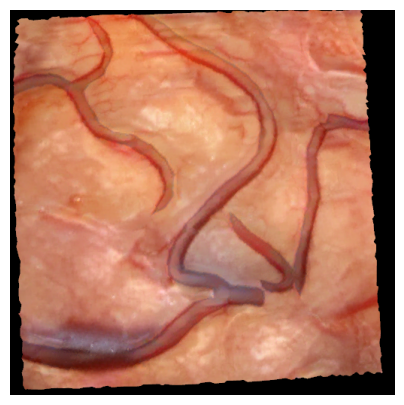

(torch.Size([512, 512, 3]), False, device(type='cuda', index=0))

In [7]:
target_image = image_to_tensor("/n/home10/dpodolskyi/neural-registration/data/datasets/0_065_cat5_2.0/images/4.png", device=nerf_model.device)
show_image(target_image.cpu())
target_image.shape, target_image.requires_grad, target_image.device

# Training

In [11]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW([final_matrix])

loss = loss_fn(rendered_image, target_image)

tensor(0.0427, device='cuda:0', grad_fn=<MseLossBackward0>)

In [22]:
camera = pipeline.datamanager.train_dataset.cameras[0].to(nerf_device)
camera.camera_to_worlds = final_matrix
nerf_model = nerf_model.train()
target_image = image_to_tensor("/n/home10/dpodolskyi/neural-registration/data/datasets/0_065_cat5_2.0/images/4.png", device=nerf_model.device)

for i in range(10):
    rendered_image = nerf_model.get_outputs_for_camera(camera)["rgb"]
    loss = loss_fn(rendered_image, target_image)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f"Iteration {i}: Loss = {loss.item()}")
    



RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

<bound method Module.requires_grad_ of NGPModel(
  (field): NerfactoField(
    (spatial_distortion): SceneContraction()
    (embedding_appearance): Embedding(
      (embedding): Embedding(91, 32)
    )
    (direction_encoding): SHEncoding(
      (tcnn_encoding): Encoding(n_input_dims=3, n_output_dims=16, seed=1337, dtype=torch.float16, hyperparams={'degree': 4, 'otype': 'SphericalHarmonics'})
    )
    (position_encoding): NeRFEncoding(
      (tcnn_encoding): Encoding(n_input_dims=3, n_output_dims=12, seed=1337, dtype=torch.float16, hyperparams={'n_frequencies': 2, 'otype': 'Frequency'})
    )
    (mlp_base): MLPWithHashEncoding(
      (activation): ReLU()
      (model): NetworkWithInputEncoding(n_input_dims=3, n_output_dims=16, seed=1337, dtype=torch.float16, hyperparams={'encoding': {'base_resolution': 16, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'log2_hashmap_size': 19, 'n_features_per_level': 2, 'n_levels': 16, 'otype': 'Grid', 'per_level_scale': 1.3819128274917603, 'typ

In [12]:
optimizer.zero_grad()
loss.backward()

In [13]:
optimizer.step()

In [14]:
final_matrix

Parameter containing:
tensor([[[-0.2205, -0.2182, -0.9507, -0.1176],
         [-0.9667,  0.1784,  0.1833,  0.2320],
         [ 0.1296,  0.9595, -0.2502, -0.2692]]], device='cuda:0',
       requires_grad=True)